In [0]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import xlsxwriter
from keras.models import load_model

Using TensorFlow backend.


Total Data : 3000
Bukan Dewasa : 1500
Dewasa : 1500


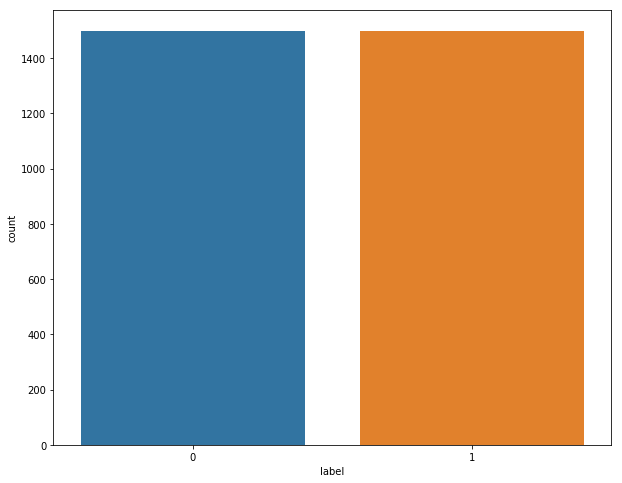

In [0]:
data = pd.read_excel("data/clean/cleansampel.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True)

dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [0]:
def get_model(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Dropout(0.9))
    model.add(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def evaluation(model, X, Y):
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    
    acc = accuracy_score(Y_act, Y_pred_class)
    
    return acc

In [0]:
text = data['tweet'].values
label = data['label'].values

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang kalimat
batch_size = 32 # penentuan jumlah sampel yang ditraining pada tiap epoch
num_epochs = 50 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2) # mengatur angka random weigth

In [0]:
#Data Train
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxlen=maxlen)
Y = to_categorical(label, num_classes = 2)

In [0]:
model = get_model(X, Y)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 128)           1018752   
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,150,594
Trainable par

In [0]:
# training model
model.fit(X, Y, batch_size=batch_size, epochs=num_epochs, verbose=1)

Epoch 1/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.6149 - acc: 0.6838
Epoch 2/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.2004 - acc: 0.9292
Epoch 3/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0913 - acc: 0.9698
Epoch 4/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0629 - acc: 0.9807
Epoch 5/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0612 - acc: 0.9820
Epoch 6/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0363 - acc: 0.9893
Epoch 7/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0173 - acc: 0.9943
Epoch 8/50
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0144 - acc: 0.9965
Epoch 9/50
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0157 - acc: 0.9950
Epoch 10/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0087 - acc: 0.9973
Epoch 11/50
3000/3000 [=====

In [0]:
acc = evaluation(model, X, label)
print("Accuracy: %.2f" % (acc*100), "%")

Accuracy: 100.00 %


In [0]:
model.save('model/pseudo_labeling.h5')

# Labeling Data

In [0]:
unlabeled = pd.read_excel("data/clean/cleandata.xlsx")
unlabeled.replace('', np.nan, inplace=True)
unlabeled.dropna(inplace=True)

In [0]:
un_text = unlabeled['tweet'].values

In [0]:
text1 = tokenizer.texts_to_sequences(un_text)
text1 = pad_sequences(text1, maxlen=maxlen)

In [0]:
pred_label = model.predict(text1)
label1 = np.argmax(pred_label, axis = 1) 

In [0]:
workbook = xlsxwriter.Workbook('data/label/label_pseudo')
worksheet = workbook.add_worksheet()

row = 0
col = 0

rowHeaders = ['tweet', 'label']
worksheet.write_row(row, col,  tuple(rowHeaders))


for i in un_text:
    tweet = i
    rowValues = [tweet]
    row += 1
    worksheet.write_row(row, col, tuple(rowValues))

row = 0
for l in label1:
    label = l
    rowValues = [label]
    row += 1 
    worksheet.write_row(row, col + 1, tuple(rowValues))

workbook.close()

# Retrained Model

In [0]:
excel_names = ["data/clean/cleansampel.xlsx", "data/label/label_pseudo.xlsx"]
excels = [pd.ExcelFile(name) for name in excel_names]

# ubah ke data frame 
# hapus header pertama, yang merupakan judul kolom
frames = [x.parse(x.sheet_names[0], header=None,index_col=None) for x in excels]
frames[1:] = [df[1:] for df in frames[1:]]

# menggabungkan dataframe
combined = pd.concat(frames)

# tulis/save ke file baru 
combined.to_excel("data/label/combineSSL1.xlsx", header=False, index=False)

In [0]:
data = pd.read_excel("data/label/combineSSL1.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True)

Total Data : 54338
Bukan Dewasa : 27192
Dewasa : 27146


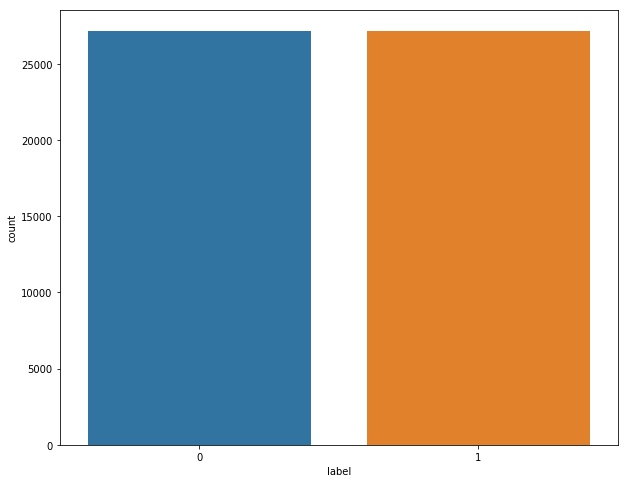

In [0]:
dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [0]:
text2 = data['tweet'].values
label2 = data['label'].values

In [0]:
data_train, data_test, label_train, label_test = train_test_split(text2, label2, test_size = 0.33, random_state = 42)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size = 0.33, random_state = 42)

In [0]:
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 2)

X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 2)

X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 2)

In [0]:
# training model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 24392 samples, validate on 12014 samples
Epoch 1/50
24392/24392 [==============================] - 96s 4ms/step - loss: 0.2154 - acc: 0.9203 - val_loss: 0.1328 - val_acc: 0.9547
Epoch 2/50
24392/24392 [==============================] - 94s 4ms/step - loss: 0.1385 - acc: 0.9509 - val_loss: 0.1222 - val_acc: 0.9569
Epoch 3/50
24392/24392 [==============================] - 94s 4ms/step - loss: 0.1224 - acc: 0.9559 - val_loss: 0.1188 - val_acc: 0.9570
Epoch 4/50
24392/24392 [==============================] - 95s 4ms/step - loss: 0.1132 - acc: 0.9587 - val_loss: 0.1173 - val_acc: 0.9573
Epoch 5/50
24392/24392 [==============================] - 94s 4ms/step - loss: 0.1067 - acc: 0.9610 - val_loss: 0.1133 - val_acc: 0.9567
Epoch 6/50
24392/24392 [==============================] - 94s 4ms/step - loss: 0.1007 - acc: 0.9617 - val_loss: 0.1133 - val_acc: 0.9580
Epoch 7/50
24392/24392 [==============================] - 94s 4ms/step - loss: 0.0942 - acc: 0.9626 - val_loss: 0.1144 - val_acc

In [0]:
acc_train = evaluation(model, X_train, label_train)
print("Train Accuracy: %.2f" % (acc_train*100), "%")

Train Accuracy: 98.75 %


In [0]:
acc_test = evaluation(model, X_test, label_test)
print("Test Accuracy: %.2f" % (acc_test*100), "%")

Test Accuracy: 96.28 %


In [0]:
model.save('model/pseudo_validation.h5')